In [50]:
# Libraries

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
import shap
from catboost import CatBoostRegressor
from urllib.request import urlopen
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [51]:
pd.set_option('display.max_rows', 1024)   #设置最大显示行数
pd.set_option('display.max_columns', 1024) #设置最大显示列数

In [52]:
#导入数据文件
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# from this kernel: https://www.kaggle.com/gravix/gradient-in-a-box
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

In [53]:
#将nan转成{}
def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

print(train.head())

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2   3                                                 {}   3300000   
3   4                                                 {}   1200000   
4   5                                                 {}         0   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                      [{'id': 18, 'name': 'Drama'}]   
3  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash/  

In [54]:
#查看数据的维度
print(train.shape)
print(test.shape)


   
    

(3000, 23)
(4398, 22)


### belongs_to_collection属性

In [55]:
#比较容易发现有些属性是字典属性，因此还需要进行处理,但并不是所有的行都有数据
 
print(train['belongs_to_collection'][0:5])
for i,e in enumerate(train['belongs_to_collection'][0:10]):
    print(i,e)

train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
1    [{'id': 107674, 'name': 'The Princess Diaries ...
2                                                   {}
3                                                   {}
4                                                   {}
Name: belongs_to_collection, dtype: object
0 [{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
1 [{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
2 {}
3 {}
4 {}
5 {}
6 {}
7 {}
8 [{'id': 256377, 'name': 'The Muppet Collection', 'poster_path': '/8Ew8EIdFFurMMYjSbWPu1Hl4vLX.jpg', 'backdrop_path': '/1AWd3MM90G47mxtD112gRDxSXY9.jpg'}]
9 {}


0    2396
1     604
Name: belongs_to_collection, dtype: int64

belongs_to_collection属性列中有2396行为空，604行的为非空。对于每个非空的属性中可能只有name的属性和是否存在collection这两个属性有用。

In [56]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x:x[0]['name'] if x!={} else 0)
train['has_collection'] = train['belongs_to_collection'].apply(lambda x:len(x) if x!={} else 0)

print(train['collection_name'][0:5])
print(train['has_collection'][0:5])

test['collection_name'] = train['belongs_to_collection'].apply(lambda x:x[0]['name'] if x!={} else 0)
test['has_collection'] = train['belongs_to_collection'].apply(lambda x:len(x) if x!={} else 0)

0    Hot Tub Time Machine Collection
1    The Princess Diaries Collection
2                                  0
3                                  0
4                                  0
Name: collection_name, dtype: object
0    1
1    1
2    0
3    0
4    0
Name: has_collection, dtype: int64


### genres属性（类型题材）

In [57]:
for i,e in enumerate(train['genres'][0:5]):
    print(i,e)

print()
#是否存在没有类型题材的行
print(train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts())

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64


类型数量主要集中在2-6的范围之内 0和7的可能是异常点

In [58]:
#将所有训练条目的genres的dict转成一个列表
list_of_genres = list(train['genres'].apply(lambda x:[i['name'] for i in x] if x!={} else []).values)
print(list_of_genres)
print(len(list_of_genres))

Comedy'], ['Mystery', 'Drama'], ['Science Fiction', 'Drama'], ['War', 'Comedy'], ['Comedy'], ['Documentary'], ['History', 'Drama'], ['Drama', 'Science Fiction', 'Animation'], ['Drama', 'Comedy'], ['Comedy'], ['Comedy', 'Drama'], ['Comedy', 'Family', 'Music', 'Romance'], ['Comedy', 'Romance'], ['Drama'], ['Drama', 'Action', 'Romance'], ['Action', 'Science Fiction', 'Adventure'], ['Romance', 'Comedy', 'Drama'], ['Adventure', 'Action', 'Thriller'], ['Drama'], ['Action', 'Adventure', 'Comedy'], ['Fantasy', 'Comedy'], ['Action', 'Thriller', 'Crime', 'Mystery'], ['Drama'], ['Drama', 'Horror', 'Thriller'], ['Drama'], ['Comedy'], ['Action', 'Thriller', 'Adventure'], ['Action', 'Adventure', 'Comedy'], ['Drama', 'Thriller', 'Crime'], ['Action', 'Comedy'], ['Action', 'Comedy', 'Drama', 'Romance'], ['Drama'], ['Comedy', 'Romance'], ['Horror', 'Comedy'], ['Horror', 'Thriller'], ['Comedy'], ['Drama', 'Romance'], ['Action', 'Adventure', 'Drama', 'History', 'Romance', 'War'], ['Comedy', 'Drama', 'Fami

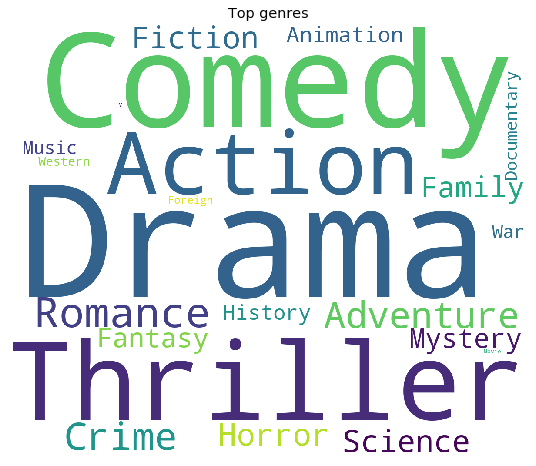

In [59]:
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top genres')
plt.axis("off")
plt.show()


In [60]:
Counter([i for j in list_of_genres for i in j]).most_common()


[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

可以看到comedy、Drama、Thriller是使用最多的类型。
给每个类型单独设置一个属性表示是否有该类型，并添加类型数量的feature

In [61]:
train['num_genres'] = train['genres'].apply(lambda x:len(x) if x!={} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x!={} else '') 
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(15)]
for g in top_genres:
    train['genre_'+g] = train['all_genres'].apply(lambda x:1 if g in x else 0)

test['num_genres'] = test['genres'].apply(lambda x: len(x) if x != {} else 0)
test['all_genres'] = test['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_genres:
    test['genre_' + g] = test['all_genres'].apply(lambda x: 1 if g in x else 0)

#删掉原始的genres
train = train.drop(['genres'], axis=1)
test = test.drop(['genres'], axis=1)
print(train.head())

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2   3                                                 {}   3300000   
3   4                                                 {}   1200000   
4   5                                                 {}         0   

                            homepage    imdb_id original_language  \
0                                NaN  tt2637294                en   
1                                NaN  tt0368933                en   
2  http://sonyclassics.com/whiplash/  tt2582802                en   
3         http://kahaanithefilm.com/  tt1821480                hi   
4                                NaN  tt1380152                ko   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                         

### production_companies属性

In [62]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)
    
print('Number of production companies in films')
train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()


0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}
Number of production companies in films


1     775
2     734
3     582
4     312
5     166
0     156
6     118
7      62
8      42
9      29
11      7
10      7
12      3
16      2
15      2
14      1
13      1
17      1
Name: production_companies, dtype: int64

可以看到 制作公司的属性数量集中在1-6个的，绝大多数有1-3个制作公司，但是也有存在10+个制作公司的电影。

In [63]:
train[train['production_companies'].apply(lambda x:len(x) if x!={} else 0)>11]

id                              belongs_to_collection    budget  \
31      32                                                 {}         0   
116    117                                                 {}         0   
363    364                                                 {}  15400000   
392    393                                                 {}         0   
449    450                                                 {}  80000000   
554    555                                                 {}  14500000   
1079  1080                                                 {}   7000000   
2170  2171                                                 {}   4000000   
2395  2396                                                 {}         0   
2517  2518  [{'id': 2396, 'name': 'Asterix and Obelix Coll...  97250400   

                                               homepage    imdb_id  \
31                          http://www.cache-derfilm.at  tt0387898   
116                                                 NaN  tt2113822   
363                                                 NaN  tt2053425   
392                                                 NaN  tt5072406   
449              http://asoundofthunder.warnerbros.com/  tt0318081   
554                                                 NaN  tt0293416   
1079                                                NaN  tt2737050   
2170  http://tickets.picturehouseentertainment.co.uk...  tt3464902   
2395                                                NaN  tt4082068   
2517  http://www.asterixauxjeuxolympiques.com/index.php  tt0463872   

     original_language               original_title  \
31                  fr                        Caché   
116                 zh                         一九四二   
363                 fr           De rouille et d'os   
392                 fr                         Moka   
449                 en           A Sound of Thunder   
554                 ja                   Metropolis   
1079                fr         Deux jours, une nuit   
2170                en                  The Lobster   
2395                fr                      Dheepan   
2517                fr  Astérix aux Jeux Olympiques   

                                               overview  popularity  \
31    A married couple is terrorized by a series of ...    5.695860   
116   In 1942, Henan Province was devastated by the ...    1.678013   
363   Put in charge of his young son, Ali leaves Bel...    8.400049   
392   Diane Kramer is led by one obsession: to find ...    2.404466   
449   When a hunter sent back to the prehistoric era...    4.980191   
554   Duke Red has overseen the construction of a ma...    9.298092   
1079  Sandra is a young woman who has only one weeke...    6.868022   
2170  In a dystopian near future, single people, acc...   11.223033   
2395  Dheepan is a Sri Lankan Tamil warrior who flee...    5.752416   
2517  Ast√©rix and Ob√©lix have to win the Olympic G...    9.671944   

                           poster_path  \
31    /i1Zl8S4DgM3IDLW5dhZzBnIdCOe.jpg   
116    /xxz2gi8vijqqJySGO3kQy2i8mv.jpg   
363   /cHCwW8xPl8yPKQwpNzKVinwvirT.jpg   
392   /5VKVaTJJsyDeOzY6fLcyTo1RA9g.jpg   
449   /gsqOX1ReJ5lcmTuDdkhOXLug8Ug.jpg   
554   /1EK7mGCpRKYmSg25FaojvnS9opm.jpg   
1079  /1mYAejpMskvskGr0J0SaBvdjmrH.jpg   
2170  /yR60EqMGS9hHq9I5Pkq2hG984TP.jpg   
2395  /lgONuekbRlM0eMvMHJBEDL6MsBP.jpg   
2517  /tKL0RJOeuccc1rrpcDKg8qhedIz.jpg   

                                   production_companies  \
31    [{'name': 'Les Films du Losange', 'id': 223}, ...   
116   [{'name': 'Emperor Motion Pictures', 'id': 272...   
363   [{'name': 'France 2 Cinéma', 'id': 83}, {'name...   
392   [{'name': 'Canal+', 'id': 5358}, {'name': 'Cin...   
449   [{'name': 'Epsilon Motion Pictures', 'id': 117...   
554   [{'name': 'Bandai Visual Company', 'id': 528},...   
1079  [{'name': 'BIM Distribuzione', 'id': 225}, {'n...   
2170  [{'name': 'Haut et Court', 'id': 726}, {'name'...   
2395  [{'name': 'France 2 Cin

公司列表

In [64]:
list_of_companies = list(train['production_companies'].apply(lambda x:[i['name'] for i in x] if x!={} else[]).values)
print(list_of_companies)

ductions'], ['The Mirisch Corporation'], ['Paramount Pictures'], ['Mann/Caan Productions'], ['Paramount Pictures', 'Columbus Circle Films'], [], ['Gaumont'], ['Pt. Merantau Films', 'XYZ Films'], ['PolyGram Filmed Entertainment'], ['Rainforest Films'], ['New Line Cinema'], ['Regency Enterprises', 'Alcor Films', 'Canal+', 'Warner Bros.'], ['Carmel Entertainment', 'Provident Films', 'Samuel Goldwyn Films', 'Affirm Films', 'Sherwood Pictures'], ['Incorporated Television Company', 'Henson Associates (HA)'], ['Lions Gate', 'Lions Gate Entertainments'], ['Orion Pictures'], ['New World Pictures'], ['Atípica Films', 'Atresmedia Cine', 'Sacromonte Films', 'Zeta Zinema'], ['Lightyear Entertainment'], ['GK Films'], [], ['New Line Cinema', 'Tiara Blu Films'], ['New Line Cinema', 'Capella International', 'KC Medien AG'], ['New Line Cinema', 'World Wrestling Entertainment (WWE)'], ['Ingenious Film Partners', 'Dino de Laurentiis Cinematografica', 'Dino De Laurentiis Company', 'Zephyr Films', 'Red Lion

统计最常见的前30名的制作公司

In [65]:
Counter([i for j in list_of_companies for i in j]).most_common(30)

[('Warner Bros.', 202),
 ('Universal Pictures', 188),
 ('Paramount Pictures', 161),
 ('Twentieth Century Fox Film Corporation', 138),
 ('Columbia Pictures', 91),
 ('Metro-Goldwyn-Mayer (MGM)', 84),
 ('New Line Cinema', 75),
 ('Touchstone Pictures', 63),
 ('Walt Disney Pictures', 62),
 ('Columbia Pictures Corporation', 61),
 ('TriStar Pictures', 53),
 ('Relativity Media', 48),
 ('Canal+', 46),
 ('United Artists', 44),
 ('Miramax Films', 40),
 ('Village Roadshow Pictures', 36),
 ('Regency Enterprises', 31),
 ('BBC Films', 30),
 ('Dune Entertainment', 30),
 ('Working Title Films', 30),
 ('Fox Searchlight Pictures', 29),
 ('StudioCanal', 28),
 ('Lionsgate', 28),
 ('DreamWorks SKG', 27),
 ('Fox 2000 Pictures', 25),
 ('Summit Entertainment', 24),
 ('Hollywood Pictures', 24),
 ('Orion Pictures', 24),
 ('Amblin Entertainment', 23),
 ('Dimension Films', 23)]

添加属性（是否拥有前30的制作公司、拥有哪些公司、拥有制作公司的总数）

In [66]:
train['num_companies'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_production_companies'] = train['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_companies = [m[0] for m in Counter([i for j in list_of_companies for i in j]).most_common(30)]
for g in top_companies:
    train['production_company_' + g] = train['all_production_companies'].apply(lambda x: 1 if g in x else 0)
    
test['num_companies'] = test['production_companies'].apply(lambda x: len(x) if x != {} else 0)
test['all_production_companies'] = test['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_companies:
    test['production_company_' + g] = test['all_production_companies'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_companies', 'all_production_companies'], axis=1)
test = test.drop(['production_companies', 'all_production_companies'], axis=1)


### production_countries

In [67]:
for i, e in enumerate(train['production_countries'][:5]):
    print(i, e)
    
print('Number of production countries in films')
train['production_countries'].apply(lambda x: len(x) if x != {} else 0).value_counts()

0 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
1 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
2 [{'iso_3166_1': 'US', 'name': 'United States of America'}]
3 [{'iso_3166_1': 'IN', 'name': 'India'}]
4 [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
Number of production countries in films


1    2222
2     525
3     116
4      57
0      55
5      21
6       3
8       1
Name: production_countries, dtype: int64

统计出现次数前25的国家

In [68]:
list_of_countries = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_countries for i in j]).most_common(25)


[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15),
 ('Czech Republic', 14),
 ('Denmark', 13),
 ('Brazil', 12),
 ('Luxembourg', 10),
 ('South Africa', 10)]

In [69]:
train['num_countries'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_countries'] = train['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(25)]
for g in top_countries:
    train['production_country_' + g] = train['all_countries'].apply(lambda x: 1 if g in x else 0)
    
test['num_countries'] = test['production_countries'].apply(lambda x: len(x) if x != {} else 0)
test['all_countries'] = test['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_countries:
    test['production_country_' + g] = test['all_countries'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['production_countries', 'all_countries'], axis=1)
test = test.drop(['production_countries', 'all_countries'], axis=1)

### Spoken languages

In [70]:
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i, e)
   

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [71]:
print('Number of spoken languages in films')
train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of spoken languages in films


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [72]:
list_of_languages = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_languages for i in j]).most_common(15)


[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27)]

In [73]:
train['num_languages'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_languages'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_languages = [m[0] for m in Counter([i for j in list_of_languages for i in j]).most_common(30)]
for g in top_languages:
    train['language_' + g] = train['all_languages'].apply(lambda x: 1 if g in x else 0)
    
test['num_languages'] = test['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
test['all_languages'] = test['spoken_languages'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_languages:
    test['language_' + g] = test['all_languages'].apply(lambda x: 1 if g in x else 0)

train = train.drop(['spoken_languages', 'all_languages'], axis=1)
test = test.drop(['spoken_languages', 'all_languages'], axis=1)
print(train.head())

  /aTXRaPrWSinhcmCrcfJK17urp3F.jpg       3/9/12    122.0  Released   
4  /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg       2/5/09    118.0  Released   

                                             tagline  \
0  The Laws of Space and Time are About to be Vio...   
1  It can take a lifetime to find true love; she'...   
2    The road to greatness can take you to the edge.   
3                                                NaN   
4                                                NaN   

                                      title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                Marine Boy   

                                            Keywords  \
0  [{'id': 4379, 'name': 'time travel'}, {'id': 9...   
1  [{'id': 2505, 'name': 'coronation'}, {'id': 42...   
2  [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...   
3  [{'id': 100

### Keywords


In [74]:
for i,e in enumerate(train['Keywords'][:5]):
    print(i,e)

0 [{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
1 [{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
2 [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
3 [{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'ne

In [76]:
print('number of Keywords in films')
train['Keywords'].apply(lambda x:len(x) if x!={} else 0).value_counts().head(10)

number of Keywords in films


5    293
0    276
4    248
3    228
6    227
2    207
7    192
1    187
8    161
9    134
Name: Keywords, dtype: int64

用词汇图找出最常见的形容电影的词汇

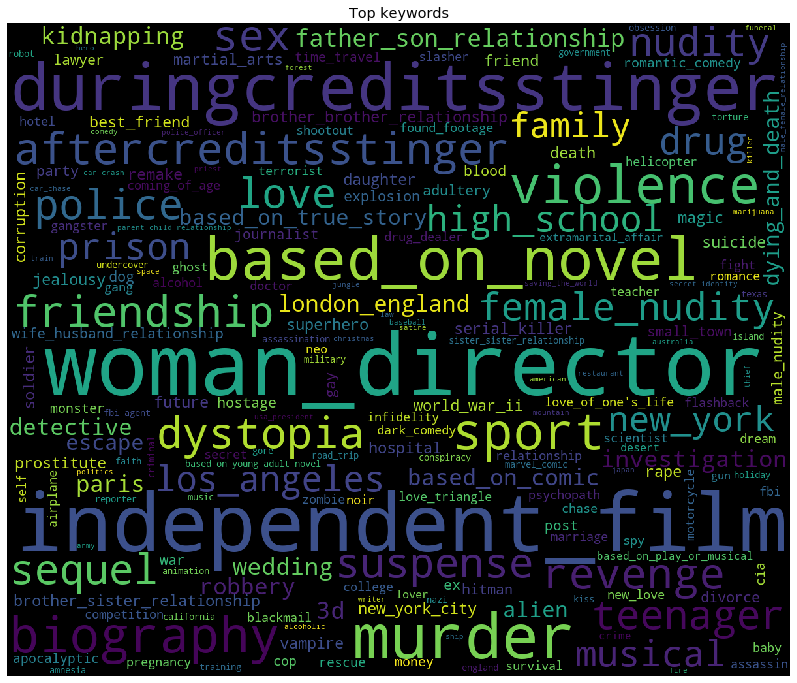

In [79]:
list_of_keywords = list(train['Keywords'].apply(lambda x:[i['name'] for i in x] if x!={} else []).values)
#print(list_of_keywords)
plt.figure(figsize = (16,12))
text = ' '.join(['_'.join(i.split(' ')) for j in list_of_keywords for i in j])
wordcloud = WordCloud(max_font_size=None,background_color='black',collocations=False,width=1200,height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top keywords')
plt.axis('off')
plt.show()


选取前30常见的作为特征

In [81]:
train['num_Keywords'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_Keywords'] = train['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_keywords = [m[0] for m in Counter([i for j in list_of_keywords for i in j]).most_common(30)]
for g in top_keywords:
    train['keyword_' + g] = train['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
test['num_Keywords'] = test['Keywords'].apply(lambda x: len(x) if x != {} else 0)
test['all_Keywords'] = test['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
for g in top_keywords:
    test['keyword_' + g] = test['all_Keywords'].apply(lambda x: 1 if g in x else 0)
    
train = train.drop(['Keywords', 'all_Keywords'], axis=1)
test = test.drop(['Keywords', 'all_Keywords'], axis=1)

### cast

In [85]:
#train['cast'][0]
for i,e in enumerate(train['cast'][:1]):
    print(i,e)

0 [{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'characte

In [86]:
print('Number of casted persons in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

Number of casted persons in films


15    212
16    165
10    135
13    129
12    124
11    122
9     118
17    118
18    115
14    110
Name: cast, dtype: int64

最常出现的前15位cast

In [87]:
list_of_cast_names = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_names for i in j]).most_common(15)


[('Samuel L. Jackson', 30),
 ('Robert De Niro', 30),
 ('Morgan Freeman', 27),
 ('J.K. Simmons', 25),
 ('Bruce Willis', 25),
 ('Liam Neeson', 25),
 ('Susan Sarandon', 25),
 ('Bruce McGill', 24),
 ('John Turturro', 24),
 ('Forest Whitaker', 23),
 ('Willem Dafoe', 23),
 ('Bill Murray', 22),
 ('Owen Wilson', 22),
 ('Nicolas Cage', 22),
 ('Sylvester Stallone', 21)]

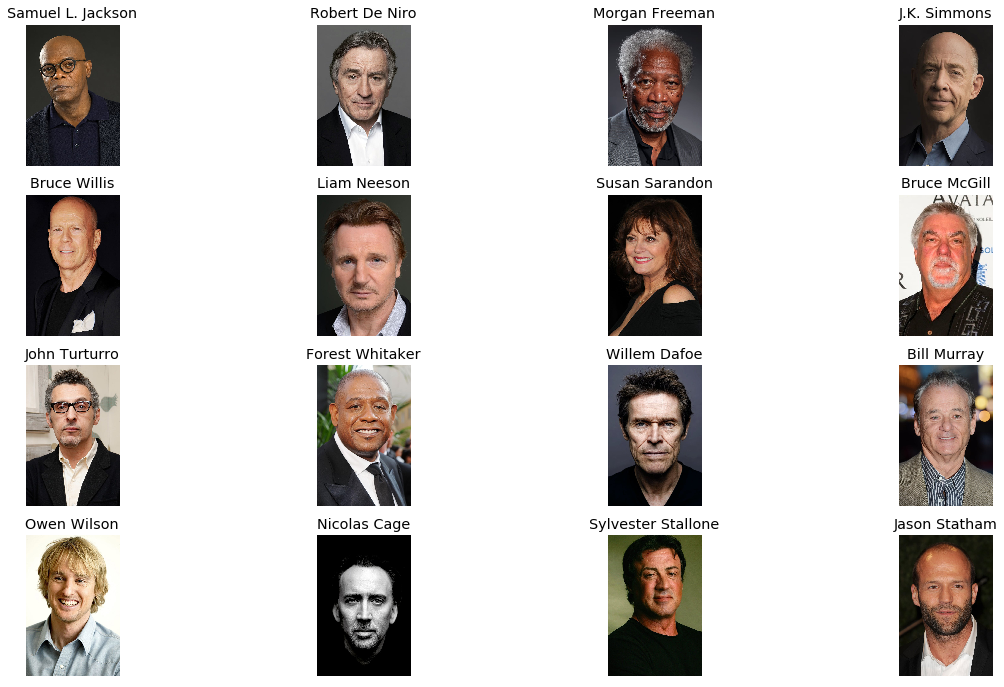

In [88]:
list_of_cast_names_url = list(train['cast'].apply(lambda x: [(i['name'], i['profile_path']) for i in x] if x != {} else []).values)
d = Counter([i for j in list_of_cast_names_url for i in j]).most_common(16)
fig = plt.figure(figsize=(20, 12))
for i, p in enumerate([j[0] for j in d]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
    plt.imshow(im)
    ax.set_title(f'{p[0]}')

In [89]:
list_of_cast_genders = list(train['cast'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_genders for i in j]).most_common()

[(2, 27949), (0, 20329), (1, 13533)]

0是未知定，1为female，2为male

In [90]:
list_of_cast_characters = list(train['cast'].apply(lambda x: [i['character'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_cast_characters for i in j]).most_common(15)

[('', 818),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44)]

In [92]:
train['num_cast'] = train['cast'].apply(lambda x: len(x) if x != {} else 0)
top_cast_names = [m[0] for m in Counter([i for j in list_of_cast_names for i in j]).most_common(15)]
for g in top_cast_names:
    train['cast_name_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_cast'] = train['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_cast_characters = [m[0] for m in Counter([i for j in list_of_cast_characters for i in j]).most_common(15)]
for g in top_cast_characters:
    train['cast_character_' + g] = train['cast'].apply(lambda x: 1 if g in str(x) else 0)
 
test['num_cast'] = test['cast'].apply(lambda x: len(x) if x != {} else 0)
for g in top_cast_names:
    test['cast_name_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_cast'] = test['cast'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for g in top_cast_characters:
    test['cast_character_' + g] = test['cast'].apply(lambda x: 1 if g in str(x) else 0)

train = train.drop(['cast'], axis=1)
test = test.drop(['cast'], axis=1)

### crew（参照cast）

In [93]:
for i, e in enumerate(train['crew'][:1]):
    print(i, e[:10])

print('Number of casted persons in films')
train['crew'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

list_of_crew_names = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

0 [{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071, 'job': 'First Assistant Director', 'name': 'Kelly Cantley', 'profile_path': None}, {'credit_id': '52fe4ee7c3a36847f82afad7', 'department': 'Directing', 'gender': 2, 'id': 3227, 'job': 'Director', 'name': 'Steve Pink', 'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'}, {'credit_id': '5524ed25c3a3687ded000d88', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Writer', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed2d925141720c001128', 'department': 'Writing', 'gender': 2, 'id': 347335, 'job': 'Characters', 'name': 'Josh Heald', 'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'}, {'credit_id': '5524ed3d92514166c1004a5d', 'department': 'Production', 'gender': 2, 'id': 57822, 'job': 'Producer', 'name': 'Andrew Panay', 'profile_path': None}, {'credit_id': '5524ed4bc3a3687df3000dd2', 'department': 'Production', 'gender': 0, 'id': 14

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

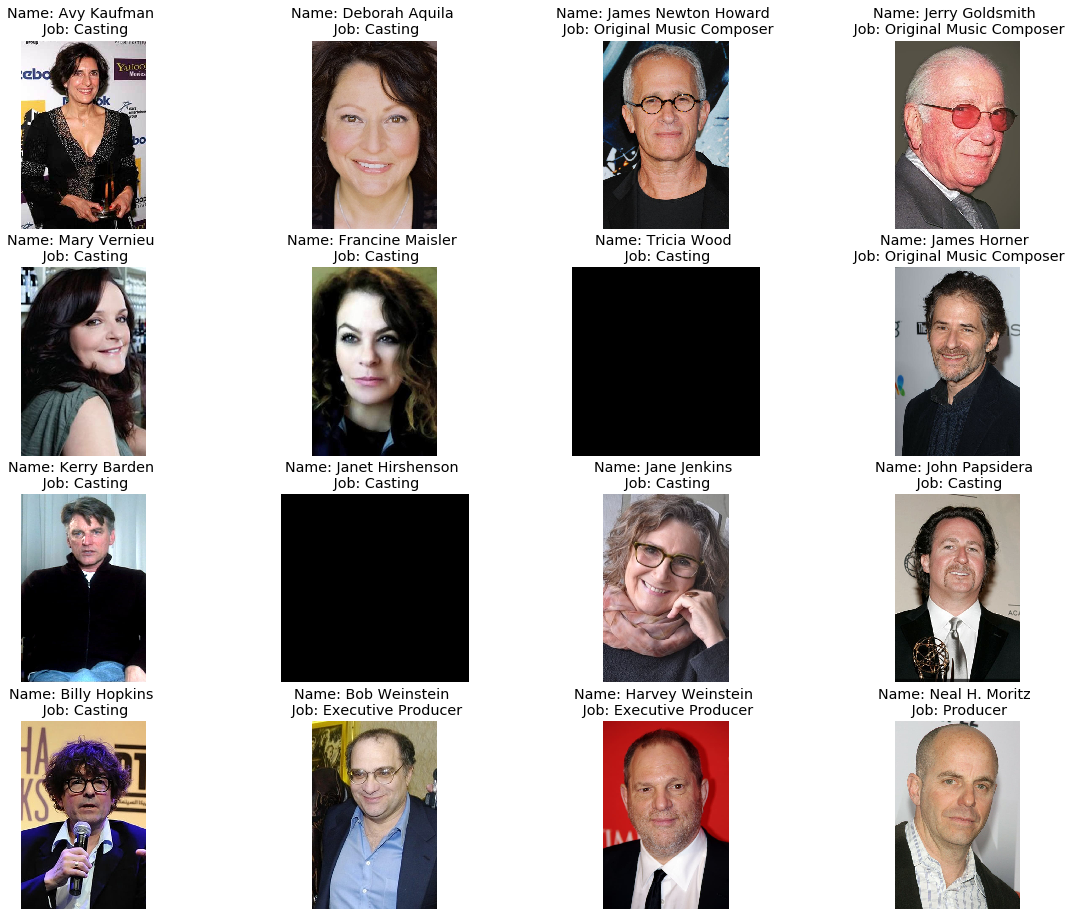

In [94]:
list_of_crew_names_url = list(train['crew'].apply(lambda x: [(i['name'], i['profile_path'], i['job']) for i in x] if x != {} else []).values)
d = Counter([i for j in list_of_crew_names_url for i in j]).most_common(16)
fig = plt.figure(figsize=(20, 16))
for i, p in enumerate([j[0] for j in d]):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    if p[1]:
        im = Image.open(urlopen(f"https://image.tmdb.org/t/p/w600_and_h900_bestv2{p[1]}"))
    else:
        im = Image.new('RGB', (5, 5))
    plt.imshow(im)
    ax.set_title(f'Name: {p[0]} \n Job: {p[2]}')

In [95]:
list_of_crew_jobs = list(train['crew'].apply(lambda x: [i['job'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)

[('Producer', 6011),
 ('Executive Producer', 3459),
 ('Director', 3225),
 ('Screenplay', 2996),
 ('Editor', 2824),
 ('Casting', 2483),
 ('Director of Photography', 2288),
 ('Original Music Composer', 1947),
 ('Art Direction', 1821),
 ('Production Design', 1650),
 ('Costume Design', 1573),
 ('Writer', 1523),
 ('Set Decoration', 1345),
 ('Makeup Artist', 1108),
 ('Sound Re-Recording Mixer', 970)]

In [96]:
list_of_crew_genders = list(train['crew'].apply(lambda x: [i['gender'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_genders for i in j]).most_common(15)

[(0, 41787), (2, 24898), (1, 6412)]

In [97]:
list_of_crew_departments = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
Counter([i for j in list_of_crew_departments for i in j]).most_common(14)

[('Production', 15887),
 ('Sound', 9319),
 ('Art', 8069),
 ('Crew', 7315),
 ('Writing', 6567),
 ('Costume & Make-Up', 6156),
 ('Camera', 5424),
 ('Directing', 4954),
 ('Editing', 4508),
 ('Visual Effects', 3591),
 ('Lighting', 1303),
 ('Actors', 4)]

In [98]:
list_of_crew_names = train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values
Counter([i for j in list_of_crew_names for i in j]).most_common(15)

[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30)]

In [100]:
train['num_crew'] = train['crew'].apply(lambda x: len(x) if x != {} else 0)
top_crew_names = [m[0] for m in Counter([i for j in list_of_crew_names for i in j]).most_common(15)]
for g in top_crew_names:
    train['crew_name_' + g] = train['crew'].apply(lambda x: 1 if g in str(x) else 0)
train['genders_0_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train['genders_1_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train['genders_2_crew'] = train['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
top_crew_jobs = [m[0] for m in Counter([i for j in list_of_crew_jobs for i in j]).most_common(15)]
for j in top_crew_jobs:
    train['jobs_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
top_crew_departments = [m[0] for m in Counter([i for j in list_of_crew_departments for i in j]).most_common(15)]
for j in top_crew_departments:
    train['departments_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 
    
test['num_crew'] = test['crew'].apply(lambda x: len(x) if x != {} else 0)
for g in top_crew_names:
    test['crew_name_' + g] = test['crew'].apply(lambda x: 1 if g in str(x) else 0)
test['genders_0_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
test['genders_1_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
test['genders_2_crew'] = test['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
for j in top_crew_jobs:
    test['jobs_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['job'] == j]))
for j in top_crew_departments:
    test['departments_' + j] = test['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

train = train.drop(['crew'], axis=1)
test = test.drop(['crew'], axis=1)

## Data Exploration

In [101]:
train.head()

0   

   production_country_Denmark  production_country_Brazil  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   

   production_country_Luxembourg  production_country_South Africa  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   num_languages  language_English  language_Français  language_Español  \
0              1                 1                  0                 0   
1              1                 1                  0                 0   
2              1                 1                  0                 0   
3              2                 1                  0                 0   
4              1                 0                  0                 0   

   language_Deutsch  language_Pусский  language_Italiano  language_日本語  \
0                 0                 0                  0             0   
1                 0                 0                  0             0   
2                 0                 0                  0             0   
3                 0                 0                  0             0   
4                 0                 0                  0             0   

   language_普通话  language_हिन्दी  language_  language_Português  \
0             0                0          1                   0   
1             0                0          1                   0   
2             0                0          1                   0   
3             0                1          1                   0   
4             0                0          1                   0   

   language_العربية  language_한국어/조선말  language_广州话 / 廣州話  language_தமிழ்  \
0                 0                 0                   0               0   
1                 0                 0                   0               0   
2                 0                 0                   0               0   
3                 0                 0                   0               0   
4                 0                 1                   0               0   

   language_Polski  language_Magyar  language_Latin  language_svenska  \
0                0                0               0                 0   
1                0                0               0                 0   
2                0                0               0                 0   
3                0                0               0                 0   
4                0                0               0                 0   

   language_ภาษาไทย  language_Český  language_עִבְרִית  language_ελληνικά  \
0                 0               0                  0                  0   
1                 0               0                  0                  0   
2                 0               0                  0                  0   
3                 0               0                  0                  0   
4                 0               0                  0                  0   

   language_Türkçe  language_Dansk  language_Nederlands  language_فارسی  \
0                0               0                    0               0   
1                0               0                    0               0   
2                0               0                    0               0   
3                0               0                    0               0   
4                0               0                    0               0   

   language_Tiếng Việt  language_اردو  language_Română  num_Keywords  \
0                    0         

### Revenue

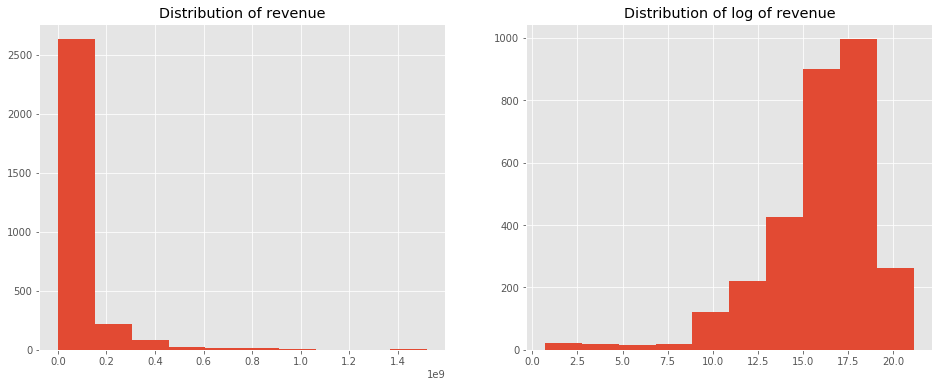

In [102]:
fig,ax = plt.subplots(figsize = (16,6))
plt.subplot(1, 2, 1)
plt.hist(train['revenue']);
plt.title('Distribution of revenue');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['revenue']));
plt.title('Distribution of log of revenue');

revenue的偏移比较严重，因此可以用log将它放缩

In [106]:
train['log_revenue'] = np.log1p(train['revenue'])

Budget

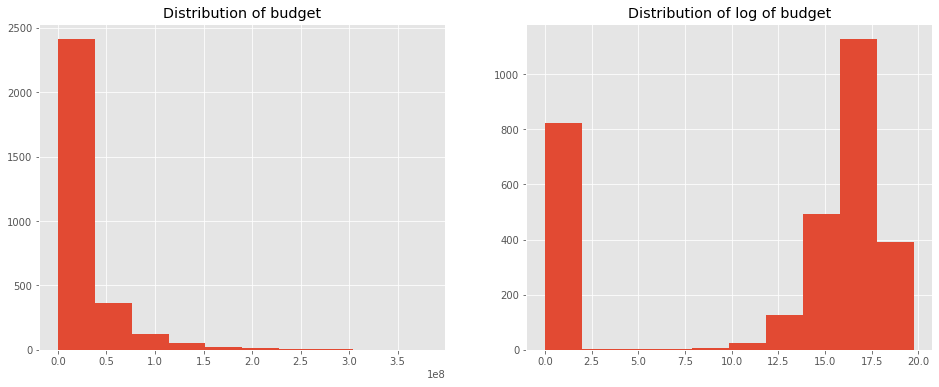

In [105]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.hist(train['budget']);
plt.title('Distribution of budget');
plt.subplot(1, 2, 2)
plt.hist(np.log1p(train['budget']));
plt.title('Distribution of log of budget');

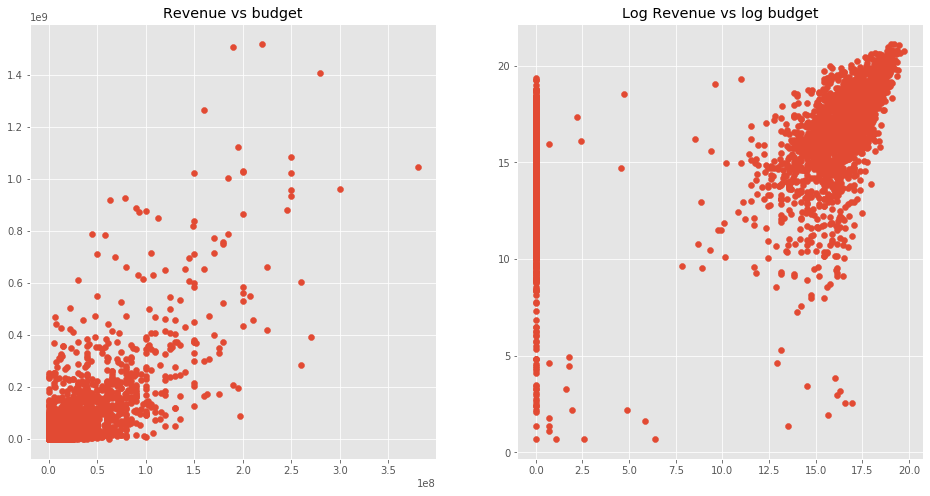

In [107]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs log budget');

In [108]:
#同样给budget取对数
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

### homepage

In [109]:
train['homepage'].value_counts().head()

http://www.transformersmovie.com/    4
http://www.lordoftherings.net/       2
http://www.thehobbit.com/            2
https://www.facebook.com/PPZMovie    1
http://www.worldwarzmovie.com        1
Name: homepage, dtype: int64

每部电影都有不一样的主页，这个属性可能是冗余的，查看是否有homepage的数量分别有多少。

In [112]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1


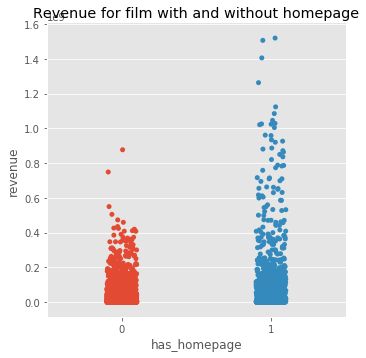

In [113]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for film with and without homepage');

看起来有homepage的电影revenue会更多一些

### original_language

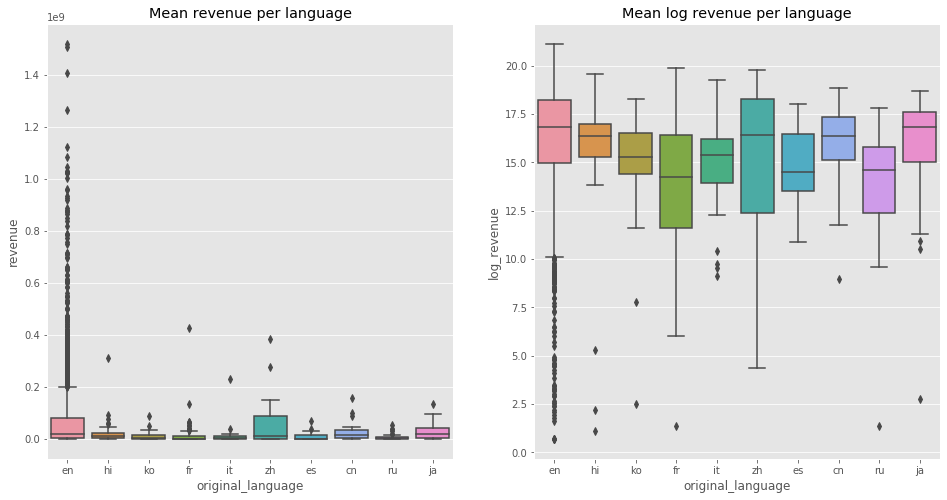

In [114]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean revenue per language');
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]);
plt.title('Mean log revenue per language');

### original_title

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in titles')
plt.axis("off")
plt.show()

### overview

In [ ]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in overview')
plt.axis("off")
plt.show()

看一下哪些词语会对revenue有影响，使用简单的*ELI5*模型进行分析。

In [117]:
vectorizer =TfidfVectorizer(sublinear_tf=True,
                            analyzer='word',
                            token_pattern=r'\w{1,}',
                            ngram_range =(1,2),
                            min_df=5)

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text,train['log_revenue'])
eli5.show_weights(linreg,vec = vectorizer,top = 20,feature_filter = lambda x:x!='<BIAS>')